# Compositional Nutrient Diagnosis

Compositional Nutrient Diagnosis (CND) is the multivariate expansion of CVA and DRIS
and is fully compatible with PCA. CND nutrient indices
are composed of two separate functions, one considering differences between nutrient levels, another examining
differences between nutrient balances (as defined by nutrient geometric means), of individual and target specimens.
These functions indicate that nutrient insufficiency can be corrected by either adding a single nutrient or taking
advantage of multiple nutrient interactions to improve nutrient balance as a whole.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from scipy.optimize import minimize

## Input concentrations of the nutrients

In [9]:
c_population = np.random.sample((10,5)) # dummy data
c_target = np.random.sample((10,5))

## The z-values $z_i$

The z-values are defined as $z_i = \log(x_i/g(x))$

- $g(x)$ is the geometric mean

In [10]:
def calculate_z(c):
    ''' Calculates z for CND analysis 
      Args:
        c (array) list of the concentration of each nutrient
      Returns:
        z (array) list of z values of each nutrient
    '''
    # normalize the nurtrient for each plant to 1
    try:
        row_sums = c.sum(axis=1)
        x = c / row_sums[:, np.newaxis]
    except Exception:
        row_sums = c.sum()
        x = c / row_sums 

    # calculate the z value for each nutrient for eveay plant
    g = (np.prod(x))**(1/len(x)) # geometric averge 
    z = np.log(x/g)
    return z

z_population = calculate_z(c_population)

# add some statistics and show the distribution of the concentration and the z values

## The CND index $I_{z_i}$

The CND index is given by $I_{z_i}=(Z_i - z_i) / \sigma_{z_i}$
- $Z_i$ is the z-value of the **test** population for nutrient $i$
- $z_i$ is the z-value of the **target** population for nutrient $i$
- $\sigma_{z_i}$ is the standard deviation of the z-value of the **target** population for nutrient $i$


This index $I_{z_i}$ is the differenz of the z-values normalized by the standart deviation of the target population.
Therefore, for each nutrient, $I_{z_i}$ measures the distance between the test and target population.

The normalization with $\sigma_{z_i}$ is to have a sensible scale. If a nutrient of the target population has a large standard deviation it means that the range of 'acceptable' nutrient amount is large. As a result the $I_{z_i}$ for this nutrient is scaled down (smaller) for this nutrient.

The interpretation of the the index $I_{z_i}$:
- $I_{z_i} < 0$: relative nutrient insufficiency
- $I_{z_i} = 0$: relative nutrient balance
- $I_{z_i} > 0$: relative nutrient excess


We can deepen the dicussion of $I_{z_i}$ by writing it as a sum and analysing each term:

$I_{z_i} = \frac{1}{\sigma_{z_i}} \biggl[\underbrace{\log\left( \frac{X_i}{x_i} \right)}_{ f(X_i)} + \underbrace{ \log\left( \frac{g(X_i)}{g(x_i)} \right)}_{ f(g(X_i))} \biggr]$

- The first term $f(X_i) = \log\left( \frac{X_i}{x_i} \right)$ is only dependent on the **individual** nutrient
- The second term $f(X_i) = \log\left( \frac{g(X_i)}{g(x_i)} \right)$ is only dependent on the geometric means $g$ therefore takes into acount **every** nutrient

In [11]:
def calculate_I(c_population, c_target):
    ''' Calculates I for CND analysis 
      Args:
        c_population (array) list of concentrations of the population
        c_target (array) list of z values of the population
      Returns:
        I (array) list of I values of each nutrient
    '''
    z_population = calculate_z(c_population)
    z_target = calculate_z(c_target)
    try:
      stds = np.std(c_target, axis=1, keepdims=True)
    except Exception:
      stds = np.std(c_target)
    Is = (z_population - z_target)/stds

    return Is 

Is = calculate_I(c_population, c_target)
Is.shape

(10, 5)

## Visualization of the I index

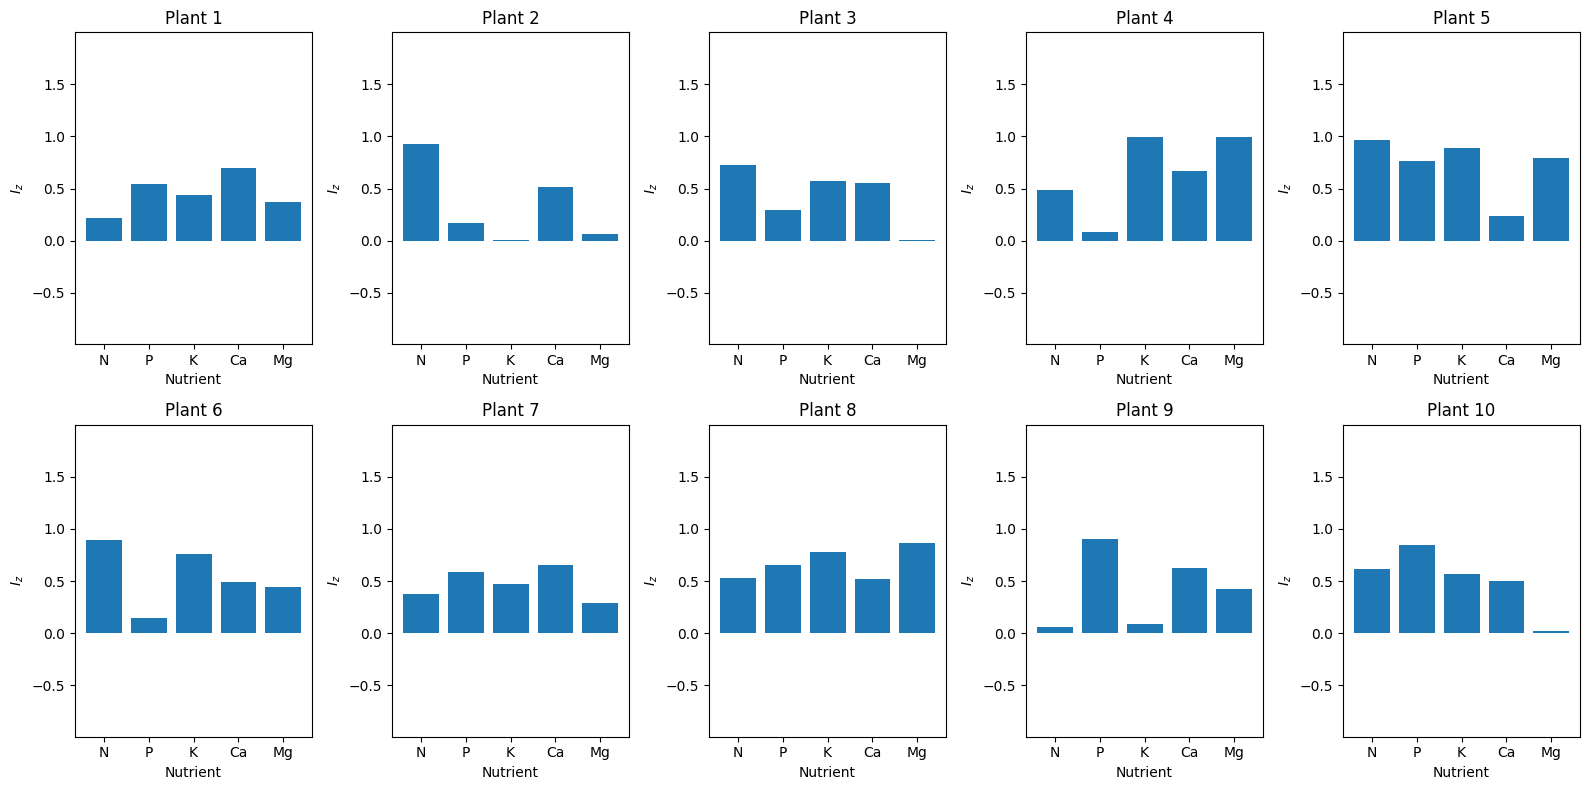

In [13]:
def plot_bar_for_each_row(data):

    data = np.array(data)
    num_rows, cols = data.shape
    
     # Adjust grid size based on data
    rows = (num_rows // cols) + (1 if num_rows%cols else 0) 
    
    # Create subplots with a grid layout
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
    axes = axes.flatten()
    
    y_min = np.min(data)
    y_max = np.max(data)
    y_shift = 1


    # Plot each row as a separate bar plot
    for i in range(num_rows):
        axes[i].bar(range(data.shape[1]), data[i, :])        
        axes[i].set_title(f'Plant {i+1}')
        axes[i].set_xlabel('Nutrient')
        axes[i].set_ylabel('$I_z$')
        axes[i].grid(False)
        axes[i].set_xticks(range(data.shape[1]))
        axes[i].set_xticklabels(['N','P','K','Ca','Mg'], rotation=0)
        axes[i].set_ylim([y_min-y_shift, y_max+y_shift])

    plt.tight_layout()
    plt.show()

plot_bar_for_each_row(Is)



In [537]:
std_nutrient = np.std(Is, axis=0)
variance_nutrient = np.var(Is, axis=0)

Interesing plots could be:

1. Distribution of Is per nutrient
2. Varience per nutrient as barplot
3. 

Text(0.5, 1.0, 'Standard deviation per nutrient')

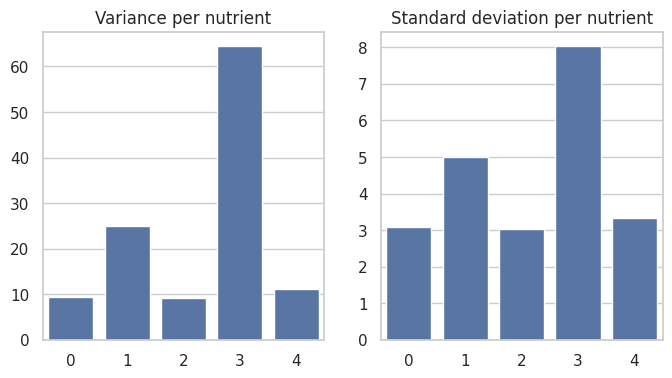

In [538]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.barplot(data=variance_nutrient, ax=ax[0])
ax[0].set_title('Variance per nutrient')
sns.barplot(data=std_nutrient, ax=ax[1])
ax[1].set_title('Standard deviation per nutrient')

## Optimizing relative fertilizer mixture

In the following we optimize the relative amount of fertilizer to get the minimal relative nutrient deficiency/excess based on the I-index.
Note, that the I value does not report about absolute concentration of nutrients. Therefore we can only obtain the relative amount.
The absolute amount of the fertilizer mixture can be obtained from a subsequent optimization, where the difference of absolute nutrient concentrations is optimized.

In [539]:
"""
In the following only a  the fertilizer mixture for plant 1 is optimized. 
This step has to be repeated for each plant.
"""

def objective_function(params, c_population, c_fertilizer1, c_fertilizer2, c_target):
    a, b = params
    # Calculate the value to be minimized
    value = np.sum(np.abs(calculate_I(
        c_population=(c_population[0, :] + a * c_fertilizer1 + b * c_fertilizer2),
        c_target=c_target[0, :]
    )))
    return value  # We want to minimize this value

def optimize_a_b(c_population, c_fertilizer1, c_fertilizer2, c_target):
    # Initial guess for a and b
    initial_guess = [0, 0]
    bounds = [(0, None), (0, None)]  # (lower bound, upper bound) for a and b
    
    # Call the optimizer
    result = minimize(objective_function, initial_guess, 
                      args=(c_population, c_fertilizer1, c_fertilizer2, c_target),
                      bounds = bounds,  # (lower bound, upper bound) for a and b
                      method='L-BFGS-B')  # BFGS is a commonly used optimization method
    
    # Extract the optimized values of a and b
    a_opt, b_opt = result.x
    return a_opt, b_opt, result.fun  # Return optimized a, b, and the minimized value


In [540]:
c_fertilizer1 = np.abs(np.random.sample(5))
c_fertilizer2 = np.abs(np.random.sample(5))
a_opt, b_opt, minimized_value = optimize_a_b(c_population, c_fertilizer1, c_fertilizer2, c_target)

print(f"{minimized_value=}")
value = calculate_I(c_population=(c_population[0,:]+a_opt*c_fertilizer1+b_opt*c_fertilizer2),c_target=c_target[0,:])
print(f"{[a_opt, b_opt]=}")
print(f"{value=}")
print(f"{np.abs(value)=}")
print(f"{np.sum(np.abs(value))=}")

minimized_value=5.974567690656485
[a_opt, b_opt]=[4.2128625386594685, 0.0]
value=array([ 5.38862642e-10, -2.07709548e+00, -5.61614850e-01,  2.98728384e+00,
       -3.48573512e-01])
np.abs(value)=array([5.38862642e-10, 2.07709548e+00, 5.61614850e-01, 2.98728384e+00,
       3.48573512e-01])
np.sum(np.abs(value))=5.974567690656485


### Constraint optimization

In [541]:
"""
Currently not converging 
"""


# Define the objective function (optional, can just return 0 since we only care about constraints)
def objective_function(params, c_population, c_fertilizer1, c_fertilizer2, c_target):
    # The objective can be something to minimize, like sum of absolute differences.
    # However, in this case, we primarily care about constraints.
    return 0  # We don't need to minimize anything, we just want the values to be within the range

# Define the constraint function (ensures values are within the specified range)
def constraint_function(params, c_population, c_fertilizer1, c_fertilizer2, c_target, lower_bounds, upper_bounds):
    a, b = params
    # Compute the values from calculate_I
    values = calculate_I(
        c_population=(c_population[0, :] + a * c_fertilizer1 + b * c_fertilizer2),
        c_target=c_target[0, :]
    )
    
    # Create constraint inequalities: lower_bounds <= values <= upper_bounds
    return np.concatenate([values - lower_bounds, upper_bounds - values])

def optimize_a_b_with_constraints(c_population, c_fertilizer1, c_fertilizer2, c_target, lower_bounds, upper_bounds):
    # Initial guess for a and b
    initial_guess = [0, 0]
    
    # Define the bounds as constraints for scipy minimize
    constraints = {
        'type': 'ineq',  # Inequality: ensures values are within bounds
        'fun': constraint_function,
        'args': (c_population, c_fertilizer1, c_fertilizer2, c_target, lower_bounds, upper_bounds)
    }
    
    # Call the optimizer
    result = minimize(objective_function, initial_guess, 
                      args=(c_population, c_fertilizer1, c_fertilizer2, c_target),
                      constraints=constraints, method='SLSQP')  # SLSQP supports constrained optimization
    
    # Extract the optimized values of a and b
    if result.success:
        a_opt, b_opt = result.x
        return a_opt, b_opt, result.fun  # Return optimized a, b, and minimized value (if applicable)
    else:
        print("Optimization failed:", result.message)
        return None, None, None  # Return None if the optimization fails

# Example usage (replace these with actual values):
lower_bounds = np.array([0.1, 0.2, 0.3, 0.4, 1])  # Example lower bounds for each of the 4 values
upper_bounds = np.array([1.0, 1.5, 2.0, 2.5, 2])  # Example upper bounds for each of the 4 values

a_opt, b_opt, minimized_value = optimize_a_b_with_constraints(c_population, c_fertilizer1, c_fertilizer2, c_target, lower_bounds, upper_bounds)


Optimization failed: Positive directional derivative for linesearch


In [542]:
# value = calculate_I(c_population=(c_population[0,:]+a_opt*c_fertilizer1+b_opt*c_fertilizer2),c_target=c_target[0,:])
# print(f"{value=}")
# print(f"{np.sum(np.abs(value))=}")

## Optimizing the absolute amount of fertilizer

In the followin we optimize the amount we have to add of this fertilizer mixture.